## Basic usage of binference for DARWIN sensitivity

Andrii Terliuk, based on Jacques example


First , let's add a location where binference in located

In [5]:
import os, sys
sys.path.append("/work/pat/terliuk/darwin_binference/master/")

And now - loading all the necessary tools

In [6]:
from binference.likelihoods.ll_darwin import InferenceObject
from binference.utils import read_neyman_threshold
from binference.likelihoods.ll_darwin import minimize_kwargs

from blueice.inference import bestfit_scipy


import numpy as np
import scipy.stats as sps
from scipy.interpolate import interp1d
from scipy import optimize
from scipy import stats
from inference_interface import toyfiles_to_numpy
import matplotlib.pyplot as plt

import pkg_resources
from tqdm import tqdm
import iminuit

Welcome to JupyROOT 6.22/08


### Let's create inference object

This will allows us to generate pseudo data toys and fit them

In [7]:
wimp_mass = 50 # injected signal WIMP mass
livetime = 200.0 # 31.48629821ty, equals to 1 year  of detector running for these templates
wimp_masses = [6,10,20,50,100,200,1000]
threshold_name = None # we can compute and create critical values from toys, but we will use 

In [8]:
darwin_stat_model = InferenceObject(wimp_mass = wimp_mass,
                                    wimp_masses=wimp_masses,
                                    livetime=livetime, limit_threshold=threshold_name,
                                   )

Computing/loading models on one core: 100%|██████████| 7/7 [00:00<00:00, 136.99it/s]


### Event expectation
we can get average event expectation for a given mass

In [9]:
exp_binference = darwin_stat_model.get_mus(wimp_mass=wimp_mass)
exp_binference

{'er': 10415.377786666379,
 'cevns': 130.24060117399782,
 'atnu': 8.716823913488039,
 'solarnu': 9804.146452542398,
 'signal': 44.044340941896166}

### And let's generate one toy experiment and look at different populations

In [120]:
inj_signal=0.
generate_args = dict(
    signal_rate_multiplier=inj_signal, # in 1e-48 cm^2
    wimp_mass = wimp_mass,
    )

Here we create "data" array, that contains cs1, log10(cs2) and origin of the event

In [121]:
datas = darwin_stat_model.simulate_and_assign_data(generate_args=generate_args)


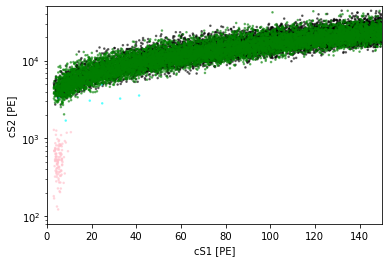

In [12]:
color_map = {0:"k",1:"pink",2:"cyan",3:"green",4:"red"}
plt.clf()
sci_data = datas[0]
colors = [color_map[s] for s in sci_data["source"]]
plt.scatter(sci_data["cs1"],10**sci_data["logcs2"],c=colors,marker=".",alpha=0.5,s=10)
plt.xlabel("cS1 [PE]")
plt.yscale("log")
plt.ylabel("cS2 [PE]")
plt.ylim([80, 50000])
plt.xlim([0, 150])
plt.show()

### Ancillary measurement
that one defines location of the constrain term w.r.t. baseline, for now - let's keep it all at baseline

In [64]:
ancillary_measurements={'er_rate_multiplier': 1.0,
                        'cevns_rate_multiplier': 1.0,
                        'atnu_rate_multiplier': 1.0,
                        'solarnu_rate_multiplier': 1.0}

#### Making toys and fits

In [124]:
n_toys= 100 # number of toys to make
test_wimp_mass = 50 # GeV/c2

### making toys and running experiments

The procedure for each toy is the following:

- create toy data and assign it
- assing (or optionally, create) ancillary measurement and assing them
- create a wrapper function that will be minimized by iminuit
- make minuit object and get best fit
- get likelihood profile using mnprofile 

In [125]:
### assigning scales (in 1e-48 cm2 in this case)
signal_scales = np.linspace(0.0, 0.64, 33)
scans = []
scans_nonmin = []
best_fits = []
####
for _ in tqdm(range(0, n_toys)):
    ## generating and assigning data
    datas = darwin_stat_model.simulate_and_assign_data(generate_args=generate_args)
    darwin_stat_model.assign_data(datas)
    ## setting constraint terms
    darwin_stat_model.assign_measurements(ancillary_measurements)
    # creating 
    llrs = np.zeros(len(signal_scales))
    ## wrapper for function to minimize
    def myll(er_rate_multiplier = 1.0, 
             cevns_rate_multiplier = 1.0,
             atnu_rate_multiplier=1.0,
             solarnu_rate_multiplier=1.0, 
             signal_rate_multiplier= 0.0
            ):
        ll_val = -1.*darwin_stat_model.ll(er_rate_multiplier=er_rate_multiplier,
                                      cevns_rate_multiplier=cevns_rate_multiplier,
                                      atnu_rate_multiplier=atnu_rate_multiplier,
                                      solarnu_rate_multiplier=solarnu_rate_multiplier,
                                      signal_rate_multiplier=signal_rate_multiplier
                                     )
        return ll_val
    ## creating minuit object
    # This is for imiuit 1, might need to change for iminuit 2
    m = iminuit.Minuit(myll, 
         er_rate_multiplier = 1.0, 
         cevns_rate_multiplier = 1.0,
         atnu_rate_multiplier=1.0,
         solarnu_rate_multiplier=1.0, 
         signal_rate_multiplier= 0.0,
         limit_er_rate_multiplier=(0.,2.), 
         limit_cevns_rate_multiplier =(0.,2.), 
         limit_atnu_rate_multiplier=(0.,2.), 
         limit_solarnu_rate_multiplier=(0.,2.),  
         limit_signal_rate_multiplier=(0.,np.inf), errordef=0.5 )
    
    res_best = m.migrad()
    _, cur_llh, _ = m.mnprofile("signal_rate_multiplier", 
                                bins =signal_scales.shape[0], 
                                bound=(signal_scales[0], signal_scales[-1]) )
    scans.append(2.*(cur_llh - res_best.fmin.fval))
    for p_ in res_best.params:
        if p_.name=="signal_rate_multiplier":
            best_fits.append(p_.value)

  0%|          | 0/100 [00:00<?, ?it/s]/toolset/py3-v1.1/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 100/100 [13:56<00:00,  8.37s/it]


### now let's find crossing points
i create spline of double LLH scans and then find an upper crossing point with critical value of 2.706, which is asymptitic value for chi2 with 1 d.o.f.

This gives us 90% C.L. upper limit 

In [126]:
# Creating splines for likelihood scans
splines = []
for i in range(n_toys):
    splines.append( interp1d(signal_scales, scans[i], kind="cubic"))   
# finding crossing point with critical value
critval = 2.706
crossings = []
for i in range(n_toys):
    crossings.append(optimize.root_scalar(lambda x: splines[i](x) - critval,
                                          bracket=(best_fits[i], signal_scales[-1])).root)
qs_= np.array([ stats.norm.cdf(v) for v in [-2.,-1.,0.,1.,2.]])
sens = np.quantile(crossings, q = qs_)

### And plotting likelihood 

(0.0, 0.64)

INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode


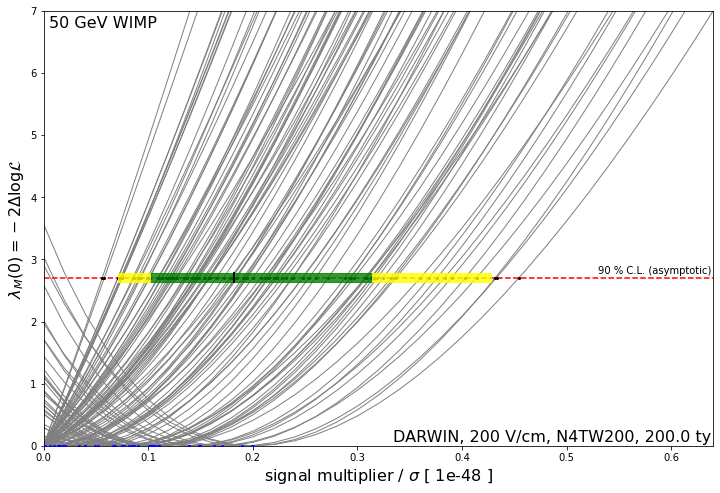

In [129]:
plt.figure(figsize=(12,8))
for i in range(n_toys):
    plt.plot(signal_scales,scans[i], c="0.5", lw=1.0)
    plt.plot(crossings[i], 2.706, marker=".", c="k", zorder=4, ms=4)
    plt.plot(best_fits[i], 0.0, marker=".", c="b", zorder=4, ms=4)

plt.fill_betweenx([critval-0.07,critval+0.07], x1 = sens[1], x2=sens[3], color="g",zorder=5, alpha=0.8 )
plt.fill_betweenx([critval-0.07,critval+0.07], x1 = sens[0], x2=sens[1], color="yellow", zorder=5, alpha=0.8 )
plt.fill_betweenx([critval-0.07,critval+0.07], x1 = sens[3], x2=sens[4], color="yellow", zorder=5, alpha=0.8 )
plt.plot([sens[2], sens[2]], 
         [critval-0.07,critval+0.07], color="k", lw=2, zorder=6)

plt.axhline(2.706, ls="--", c="r")
plt.xlabel("signal multiplier / $\sigma$ [ 1e-48 ]", fontsize=16)
plt.ylabel("$\lambda_M(0) = - 2 \Delta \log \mathcal{L}$", fontsize=16)
plt.text(0.638, 2.74, "90 % C.L. (asymptotic)", va = "bottom", ha="right")
plt.text(0.638, 0.02, "DARWIN, 200 V/cm, N4TW200, {:0.1f} ty".format(livetime), 
         va = "bottom", ha="right", fontsize=16)
plt.text( 0.005,6.92, "{:d} GeV WIMP".format(wimp_mass), 
         va = "top", ha="left", fontsize=16)

plt.ylim(0,7)
plt.xlim(0,0.64)